### Let's see if [SII] vs. [OIII] diagnostic diagram is usefull to determine the presence of shocks

In [1]:
# Import and define some useful things
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
pc.config.cloudy_exe = '/usr/local/Cloudy/c17.00/source/cloudy.exe'
dir_ = '/tmp'
pc.log_.level = 3

In [2]:
# Define a function to generate the 1D models used to build an eliptical nebula (a spherical one could do the job)
def set_models(dir_, model_name):
    emis_tab = ['H  1  4861.33A',
            'H  1  6562.85A',
            'N  2  6583.45A',
            'O  3  5006.84A',
            'S  2  6716.44A',
            'S  2  6730.82A'
            ]   
    a = 2.
    b = 1.0
    thetas = np.linspace(0., 90., 6)
    thetas_rad = np.pi / 180. * thetas
    fact_elli = a * b / np.sqrt((b * np.sin(thetas_rad))**2 + (a * np.cos(thetas_rad))**2)
    rs_in = 16.5 + np.log10(fact_elli)
    densities = 4 - np.log10(fact_elli) * 2
    
    model = pc.CloudyInput()
    model.set_BB(60000., 'q(H)', 47.3)
    model.set_grains()
    model.set_emis_tab(emis_tab)
    
    for theta, r_in, density in zip(thetas, rs_in, densities):
        model.model_name = '{0}/{1}_{2:.0f}'.format(dir_, model_name,theta)
        model.set_cste_density(density)
        model.set_radius(r_in)
        model.set_theta_phi(theta)
        model.print_input(to_file = True, verbose = False)

In [3]:
# Some parameters for the 3D model
model_name = "M3D_1"
dim = 251
n_cut = int((dim-1) /2)
proj_axis = 0

In [4]:
# Printing the input files
set_models(dir_, model_name)

     CloudyInput: Input writen in /tmp/M3D_1_0.in
     CloudyInput: Input writen in /tmp/M3D_1_18.in
     CloudyInput: Input writen in /tmp/M3D_1_36.in
     CloudyInput: Input writen in /tmp/M3D_1_54.in
     CloudyInput: Input writen in /tmp/M3D_1_72.in
     CloudyInput: Input writen in /tmp/M3D_1_90.in


In [ ]:
# Running Cloudy
pc.print_make_file(dir_ = dir_)
pc.run_cloudy(dir_ = dir_, n_proc = 6, model_name = model_name, use_make = True)

In [5]:
# Reading the cloudy results in a list of CloudyModel objects
pc.log_.level = 2
Models = pc.load_models('{0}/{1}'.format(dir_, model_name), list_elem=['H', 'He', 'C', 'N', 'O', 'Ar', 'Ne'],  
                                           read_cont = False, read_grains = False)

In [6]:
# Building the 3D model
pc.log_.level = 3
m3d = pc.C3D(Models, dims = dim, angles = [45,0,0], plan_sym = True)

     C3D: Entering C3D
     CubCoord: building a cube of 251x251x251
     CubCoord: Rotation matrix by 45.0, 0.0, 0.0 degrees.
     C3D: CubCoord done.
     C3D: interp_bi done.
     C3D: Interpolation mesh done
     C3D: All 3D values reset


## Now we can obtain the classical color image of the nebula

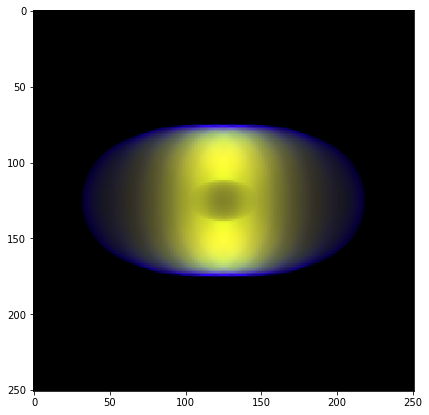

In [13]:
im = m3d.get_RGB(list_emis = [0, 3, 4])
plt.figure(1, figsize=(7,7))
plt.imshow(im);

In [14]:
# Defining the 2 monochromatic images
O3im= (m3d.get_emis('O__3_500684A').sum(axis = proj_axis) / 
       m3d.get_emis('H__1_486133A').sum(axis = proj_axis))
S2im= ((m3d.get_emis('S__2_671644A')+m3d.get_emis('S__2_673082A')).sum(axis = proj_axis) / 
       m3d.get_emis('H__1_656285A').sum(axis = proj_axis))

/home/morisset/anaconda2/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/morisset/anaconda2/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


### Let's plot the density map of the image pixels in the [SII] vs. [OIII] diagramm: 

In [9]:
# Define the density map
from scipy.stats import gaussian_kde
x = np.log10(O3im.ravel())
y = np.log10(S2im.ravel())
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

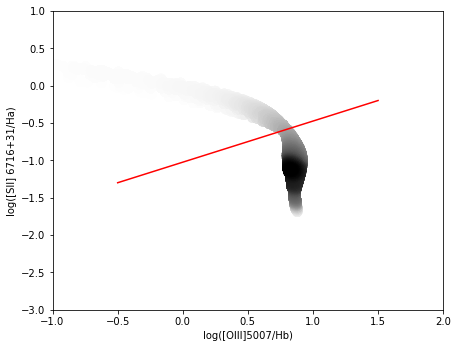

In [10]:
# Plotting the density map
fig, ax = plt.subplots(figsize=(7,5.5))
ax.scatter(x, y, c=z, s=100, edgecolor='', cmap = 'Greys')
ax.set_xlim((-1, 2))
ax.set_ylim((-3, 1))
ax.set_xlabel('log([OIII]5007/Hb)')
ax.set_ylabel('log([SII] 6716+31/Ha)')
xtab = np.linspace(-0.5, 1.5, 10)
ytab = 0.55*xtab -1.025
ax.plot(xtab, ytab, c='r');

### Let's compare to the Danehkar paper:

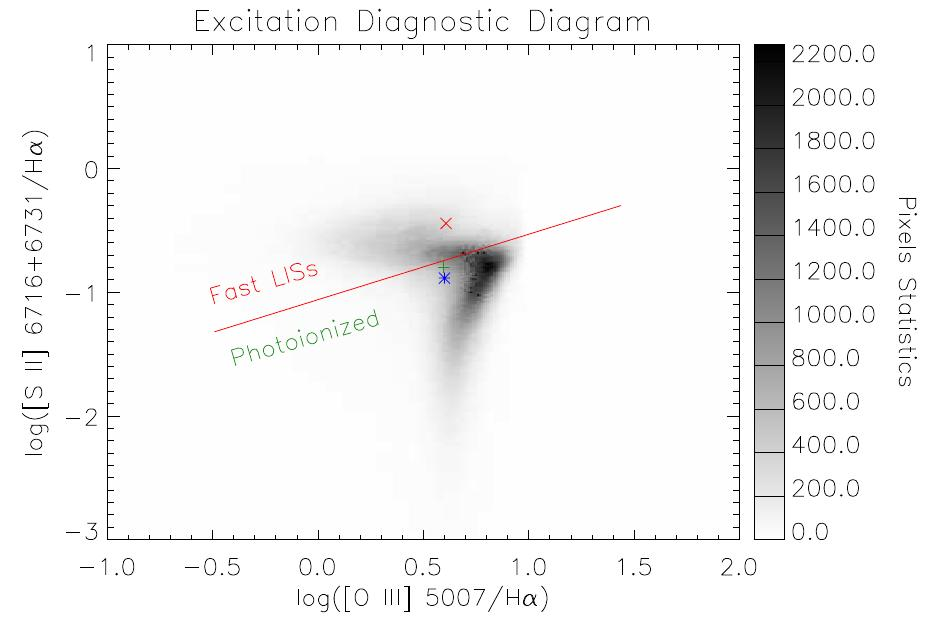

In [11]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = './Dan.jpg', width=550, height=550)

### What is claimed to be shocked regions is only simple low ionization regions